<a href="https://colab.research.google.com/github/junwin/colab/blob/main/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up a regression model for house prices using Keras and Tensorflow
Using Tensorflow, Keras and Python in Jupyter Notebooks is a popular way to develop machine learning applications.

To understand how the functionality fits in the machine learning workflow ( data preparation, training the model and evaluating the fit using test data sets) I decided to apply the tools to estimate the sale prices of houses.

The approach is similar to the sample I produced using ML.Net from Microsoft: https://towardsdatascience.com/predicting-a-house-price-using-ml-net-6555ff3caeb

We will run the code in Google's Colaboratory since this provides an excellent environment that allows access to GPU's, requires no configuration and enables sharing.

We need to sanity test the raw data we loaded to ensure the columns are in the date range we expect.  It is a good idea to check the data for any outliers; for example, in my first iteration, one home had 82 garage spots.

Be aware that there is a regional bias in the data since all the test data came from a few areas of Chicago's northern suburbs.


## Dependancies
First lets load any dependancies required.

In [ ]:
#@title Dependancies
import pandas as pd
! pip install tensorflow==2.4.0
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
from tensorflow.keras import regularizers
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

## Let's load a dataset of house sales. 
We need to sanity test the raw data we loaded to ensure the columns are in the date range we expect. It is a good idea to check the data for any outliers; for example, in my first iteration, one home had 82 garage spots. Be aware that there is a regional bias in the data since all the test data came from a few areas of Chicago's northern suburbs.


In [103]:
url="https://junwin.github.io/HouseData3.csv"
rawData=pd.read_csv(url).sample(frac=1)
rawData.describe()

,MLS#,YearClosed,SoldPr,Locale,Zip,Area,Rooms,FullBaths,HalfBaths,Beds,BsmtBeds,GarageSpaces,ParkingSpaces
count,6.851000e+03,6851.000000,6.851000e+03,6851.000000,6851.000000,6851.000000,6851.000000,6851.000000,6851.000000,6851.000000,6851.000000,6851.000000,6851.000000
mean,1.030734e+07,2018.963801,4.203940e+05,90.858415,60091.594220,2120.467815,7.750401,2.124799,0.530434,3.152168,0.130784,1.589899,0.364180
std,4.097783e+05,1.030840,2.824380e+05,64.187286,73.971679,1154.188644,2.402407,0.923679,0.577486,1.034099,0.377626,0.963217,1.048626
min,8.866215e+06,2017.000000,2.500000e+04,2.000000,60002.000000,372.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.997535e+06,2018.000000,2.430000e+05,62.000000,60062.000000,1304.000000,6.000000,2.000000,0.000000,2.000000,0.000000,1.000000,0.000000
50%,1.038995e+07,2019.000000,3.440000e+05,76.000000,60076.000000,1800.000000,7.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000
75%,1.064400e+07,2020.000000,5.200000e+05,76.000000,60077.000000,2620.000000,9.000000,2.000000,1.000000,4.000000,0.000000,2.000000,0.000000
max,1.095755e+07,2020.000000,4.300000e+06,201.000000,63104.000000,13000.000000,18.000000,8.000000,5.000000,11.000000,3.000000,11.000000,20.000000


### Features
Let's grab the features we want to model; the good thing is that its relatively easy to experiment with different features using pandas.

In [104]:
selectedFeatures = rawData[['YearClosed', 'Type', 'Area', 'Zip', 'Rooms','FullBaths','Beds','GarageSpaces']]
prices = rawData['SoldPr']
SAMPLES = len(selectedFeatures.index)
featureCount = len(selectedFeatures.columns)


### Converting enumerations
Before we can use the data we need to convert any features like type from string-based labels(e.g. Condo, Townhouse, Duplex ) to a numeric, we can use the sklearn.preprocessing tools for preprocessing and normalization.

You can use the ordinal encoder in "auto" mode to identify categories in the training data - here I have specified the columns of interest.

You need to ensure consitent types(e.g. strings, int, float) used in the columns to be converted.

In [ ]:
ordinalColumns = ['YearClosed', 'Type', 'Zip']
ordinalData = selectedFeatures[ordinalColumns]
enc = preprocessing.OrdinalEncoder()
enc.fit(ordinalData)
enc.categories

selectedFeatures[ordinalColumns] = enc.transform(ordinalData)


### Normalization
We should normalize the features and corresponding price targets to facilitate learning.

In [106]:
featureScaler = MinMaxScaler()
selectedFeaturesScale =  pd.DataFrame(featureScaler.fit_transform(selectedFeatures), columns=selectedFeatures.columns)

priceScaler = MinMaxScaler()
pricesScale =  pd.DataFrame(priceScaler.fit_transform(prices.values.reshape(-1, 1)),columns=['SoldPr'])


## Saving the Sclaers and Encoders
You will need to save the scalers and encoders if you want to use the model on its own without training.

In [ ]:
# save and load your scalers and encoders
import joblib 
joblib.dump(featureScaler, 'my_cool_scaler.pkl')
joblib.dump(priceScaler, 'my_cool_pxscaler.pkl')
joblib.dump(enc, 'my_cool_encoder.pkl')  
#see joblib.load

### Understanding the input data
It is imperative to have a good overview of the model's data, so you need to plot some of the features to check any issues. Suppose you look at the first plot of the area against price:
* there are many issues as the area increases. 
* most of the data is for smaller homes.

I am not going to address these issues here, but the input merits some scrutiny.


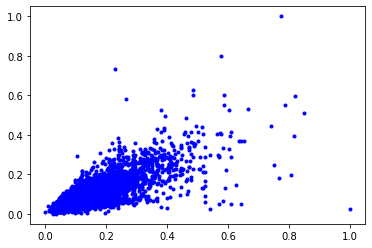

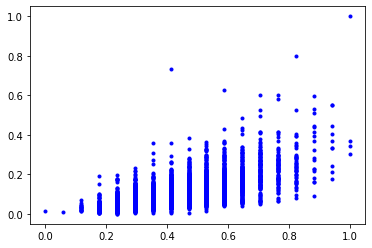

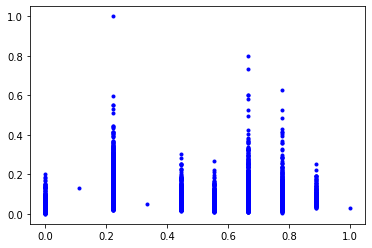

In [107]:
# Plot our data to examine the relationship between some features and price
plt.plot(selectedFeaturesScale['Area'], pricesScale, 'b.')
plt.show()
plt.plot(selectedFeaturesScale['Rooms'], pricesScale, 'b.')
plt.show()
plt.plot(selectedFeaturesScale['Zip'], pricesScale, 'b.')
plt.show()

## Separate data
We need to split our data into three parts, the first 60% is for training, 20% are set asside for validation and the last 20% for a final test.

In [108]:
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

training_examples = selectedFeaturesScale.head(TRAIN_SPLIT)
training_targets = pricesScale.head(TRAIN_SPLIT)

validation_examples = selectedFeaturesScale[TEST_SPLIT:TEST_SPLIT+int(0.2 * SAMPLES)]
validation_targets = pricesScale[TEST_SPLIT:TEST_SPLIT+int(0.2 * SAMPLES)]

test_examples = selectedFeaturesScale.tail(int(0.2 * SAMPLES))
test_targets = pricesScale.tail(int(0.2 * SAMPLES))

# Double-check that we've done the right thing.
print("Training examples summary:")
training_examples.describe()
print("Validation examples summary:")
validation_examples.describe()

print("Training targets summary:")
training_targets.describe()
print("Validation targets summary:")
validation_targets.describe()


Training examples summary:
Validation examples summary:
Training targets summary:
Validation targets summary:


,SoldPr
count,1370.000000
mean,0.091229
std,0.063498
min,0.003509
25%,0.052614
50%,0.074327
75%,0.112632
max,0.801170


## Training a model using Keras
Now we have our data we can use Keras (a high-level API to Tensorflow) to create a model.
 Keras makes it easy to experiment with different model architectures and visualize the results.

We will begin with three layers and use the "relu" activation function. Notice that the first layer uses the featureCount to define its input shape, and the final layer outputs to a single neuron since its the predicted price.

Notice that we are using some regularization in the model this is to reduce the chance of overfitting.

In [109]:
model_1 = tf.keras.Sequential()

#model_1.add(keras.layers.Dense(16, activation='relu', input_shape=(featureCount,)))
model_1.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(featureCount,)))
#model_1.add(keras.layers.Dense(16, activation='relu'))
model_1.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Having created the model, we will now train it.

In [110]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(training_examples, training_targets, epochs=500, batch_size=50,
                        validation_data=(validation_examples, validation_targets))

Epoch 1/500
83/83 [==============================] - 1s 4ms/step - loss: 0.0715 - mae: 0.1597 - val_loss: 0.0242 - val_mae: 0.0444
Epoch 2/500
83/83 [==============================] - 0s 2ms/step - loss: 0.0231 - mae: 0.0435 - val_loss: 0.0196 - val_mae: 0.0329
Epoch 3/500
83/83 [==============================] - 0s 2ms/step - loss: 0.0190 - mae: 0.0341 - val_loss: 0.0168 - val_mae: 0.0286
Epoch 4/500
83/83 [==============================] - 0s 2ms/step - loss: 0.0165 - mae: 0.0298 - val_loss: 0.0149 - val_mae: 0.0265
Epoch 5/500
83/83 [==============================] - 0s 2ms/step - loss: 0.0147 - mae: 0.0279 - val_loss: 0.0134 - val_mae: 0.0250
Epoch 6/500
83/83 [==============================] - 0s 2ms/step - loss: 0.0132 - mae: 0.0266 - val_loss: 0.0125 - val_mae: 0.0251
Epoch 7/500
83/83 [==============================] - 0s 2ms/step - loss: 0.0122 - mae: 0.0260 - val_loss: 0.0115 - val_mae: 0.0236
Epoch 8/500
83/83 [==============================] - 0s 2ms/step - loss: 0.0114 - m

### Understanding the results
Having trained our model, we now need to check the training metrics to see how the model converges. First, we will check out training over all the epochs, then show a graph that excludes some of the initial epochs to focus on whats happening nearer the end.

We can see a very rapid convergance, where the loss flatens out after about 50 epochs. On the second plot, it looks like a reasonable difference between the training and validation loss.


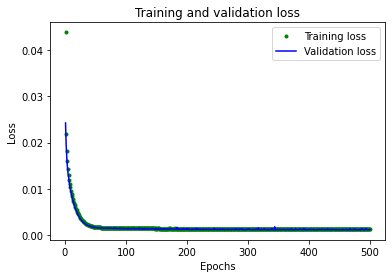

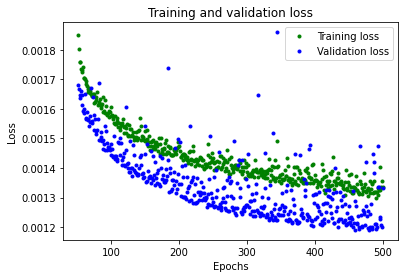

In [111]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Final test
We can now use the 20% of the data we kept aside for a final test. First, we use the model to evaluate the test data and print out the mean squared error and the mean average error for predictions. The overall loss on the test data seem to correlate well with the results seen in tthe validation set.

It's a great idea to visualize some of the data by plotting actuals against predicted results.

In [116]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(test_examples, test_targets)
print("mean squared error:", test_loss, " mean average error:", test_mae)

#y_test_pred = model_1.predict(test_examples)

# Graph the predictions against the actual values
#plt.clf()
#plt.title('Comparison of predictions and actual values')
#plt.plot( test_targets,  y_test_pred, 'b.', label='Actual values')
#plt.show()


43/43 [==============================] - 0s 945us/step - loss: 0.0013 - mae: 0.0200
mean squared error: 0.0013336228439584374  mean average error: 0.01995883882045746


## Plot a comparision of actual and predicted for a single zip
Plotting the actual values against the predcited shows reasonable results for this particular training run.

In [113]:
y_test_pred = model_1.predict(test_examples)

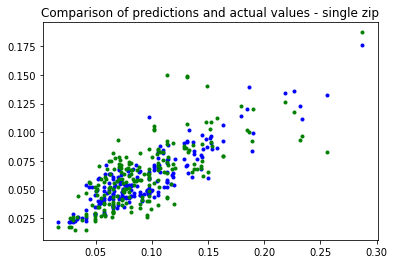

In [117]:
sampleInfo = pd.DataFrame();
samplePx = pd.DataFrame();

i=0
while i < test_examples.values.shape[0]:
  myRow =  test_examples.iloc[[i]]
  myPxRow = test_targets.iloc[[i]]

  if round(myRow['Zip'].values[0],2) == 0.56:
    sampleInfo = sampleInfo.append(myRow)
    samplePx = samplePx.append(myPxRow)
    
  i = i + 1

y_test_pred = model_1.predict(sampleInfo)

plt.clf()
plt.title('Comparison of predictions and actual values - single zip')
plt.plot( sampleInfo['Area'], y_test_pred, 'b.', label='predicted values')
plt.plot( sampleInfo['Area'], samplePx, 'g.', label='Actual values')
#plt.plot( samplePx,  y_test_pred, 'b.', label='Actual values')
plt.show()

## Run your own examples
Lets try with a couple of test inferences  - the single family home (SFH) should be lower in zip 60002 than 60076

In [ ]:


#Simple Sample
houseData = {'YearClosed': [2020.00, 2019.00, 2019.00, 2019],
	'Type': ['SFH', 'SFH', 'Condo', 'Townhouse'],
	'Area': [2940, 1500, 1500, 1500],
  'Zip': [60002, 60076, 60076, 60076],
	'Rooms': [9, 7, 7, 7],
  'FullBaths': [2.5, 2.5, 2.5, 2.5],
  'Beds': [4, 3, 3, 3],
  'GarageSpaces': [2, 2, 0, 0]  }

houseInfo = pd.DataFrame(houseData)
ordinalData = houseInfo[ordinalColumns]
houseInfo[ordinalColumns] = enc.transform(ordinalData)


houseInfo =  pd.DataFrame(featureScaler.transform(houseInfo), columns=houseInfo.columns)
newPrices = priceScaler.inverse_transform(model_1.predict(houseInfo))
print(newPrices)





# Optional fun

If we are happy with the model we can now convert and save it - I choose to save the model using Tensorflow lite to be able to run it on a small device.


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open("housePriceModelNoQuantization", "wb").write(model_no_quant_tflite)


If you want to run the model using C on some smaller device (e.g. a Raspberry Pi) you can dump the model weightd as a C++ file.


In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i housePriceModelNoQuantization > model_1.cc
!cat model_1.cc
# Update variable names
#REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
#!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}